## Exendend tests on processing time w.r.t number of dem pixel

This workbook tests (i) the processing time of the geometric corrections and (ii) the radiometric corrections of the terrain against the number of points in the input DEM.
We will use a 10-meter DEM resampled at 5 meter, 10 meter, 20 meter, 30 meter.

As an example, we use data convering the South-of-Redmond region (Seattle, US). Both the input GRD and DEM will be downloaded from the Planatery Computer.

**Note**: Download/retrieval steps are slower on local machines compared to the Planetary Computer. In future versions, it will be possible to access data via [fsspec](https://filesystem-spec.readthedocs.io/en/latest/) without having to download data locally.

<hr style="border:2px solid blue"> </hr>

### Install Dependencies and Import
Additional dependecies: `sarsen`

In [1]:
!pip install -q sarsen

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 7)
plt.rcParams.update({"font.size": 22})

In [3]:
import os
import tempfile
import time

# enable the `.rio` accessor
import rioxarray  # noqa: F401
import xarray as xr

from sarsen import apps

In [4]:
import adlfs
import planetary_computer
import pystac_client
import stackstac

### Processing definitions

In [5]:
# create a temporary directory where to store downloaded data
tmp_dir = tempfile.gettempdir()

# DEM path
dem_05_path = os.path.join(tmp_dir, "South-of-Redmond-05.tif")
dem_10_path = os.path.join(tmp_dir, "South-of-Redmond-10.tif")
dem_20_path = os.path.join(tmp_dir, "South-of-Redmond-20.tif")
dem_30_path = os.path.join(tmp_dir, "South-of-Redmond-30.tif")

# path to Sentinel-1 input product in the Planetary Computer
product_folder = "GRD/2021/12/17/IW/DV/S1B_IW_GRDH_1SDV_20211217T141304_20211217T141329_030066_039705_9048"  # noqa: E501

# band to be processed
measurement_group = "IW/VV"

tmp_dir

'/var/folders/6c/fks7jkkx5_75gpkvzd1cbx100000gp/T'

#### Area of interest definition: South-of-Redmond (Seattle, US)

In [6]:
lon, lat = [-121.95, 47.04]
buffer = 0.2
bbox = [lon - buffer, lat - buffer, lon + buffer, lat + buffer]

#### DEMs discovery

Here we use the DEM with a 10-meter ground sample distance (GDS) available on the Planetary Computer. Note that **any DEM supported by GDAL/Proj can be used**.

Using `pystac_client` we can search the Planetary Computer's STAC endpoint for items matching our query parameters.  
As multiple DEMs acquired at different times are available in this area, we select the DEMs with 10-meter GDS and perform the average of the remaining DEMs along the time dimension.

In [7]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1"
)
search = catalog.search(collections="3dep-seamless", bbox=bbox)
items = list(search.get_items())

Here we load the data into an xarray `DataArray` using stackstac.

In [8]:
# select DEMs with resolution 10 meters
items_high_res = [
    planetary_computer.sign(item).to_dict()
    for item in items
    if item.properties["gsd"] == 10
]

dem_raster_all = stackstac.stack(items_high_res, bounds=bbox).squeeze()
dem_raster_all

<xarray.DataArray 'stackstac-d3400c518e971978aeee52cc4628365e' (time: 4,
                                                                y: 4321, x: 4321)>
dask.array<getitem, shape=(4, 4321, 4321), dtype=float64, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/13)
  * time             (time) datetime64[ns] 2018-02-02 2018-02-08 ... 2020-01-07
    id               (time) <U10 'n48w122-13' 'n47w122-13' ... 'n48w123-13'
    band             <U4 'data'
  * x                (x) float64 -122.2 -122.1 -122.1 ... -121.8 -121.8 -121.8
  * y                (y) float64 47.24 47.24 47.24 47.24 ... 46.84 46.84 46.84
    proj:shape       object {10812}
    ...               ...
    gsd              int64 10
    threedep:region  <U7 'n40w130'
    proj:epsg        int64 5498
    end_datetime     (time) <U20 '2016-12-31T00:00:00Z' ... '2019-04-25T00:00...
    description      <U1849 'This tile of the 3D Elevation Program (3DEP) sea...
    epsg             int64 5498
Attributes:
    spec:        RasterSpec(epsg=5498, bounds=(-122.15000053746, 46.839907613...
    crs:         epsg:5498
    transform:   | 0.00, 0.00,-122.15|\n| 0.00,-0.00, 47.24|\n| 0.00, 0.00, 1...
    resolution:  9.2592593e-05

#### DEMs average along the time dimension

In [9]:
dem_raster_geo = dem_raster_all.compute()
if "time" in dem_raster_geo.dims:
    dem_raster_geo = dem_raster_geo.mean("time")
_ = dem_raster_geo.rio.set_crs(dem_raster_all.rio.crs)

#### Convert the DEM in UTM coordinates and resample

In order to facilitate the comparison between the RTC computed by sarsen with the RTC available on the Planetery Computer, here we convert the DEM in UTM.

In [10]:
dem_raster_geo

<xarray.DataArray 'stackstac-d3400c518e971978aeee52cc4628365e' (y: 4321, x: 4321)>
array([[ 163.69631958,  162.63404846,  162.2134552 , ...,  663.19958496,
         660.66424561,  658.06341553],
       [ 163.07417297,  162.64425659,  162.26867676, ...,  665.82775879,
         663.2644043 ,  660.68115234],
       [ 163.33903503,  162.73181152,  162.52307129, ...,  668.45983887,
         665.91448975,  663.2935791 ],
       ...,
       [ 497.75076294,  498.00402832,  498.57537842, ..., 3596.11181641,
        3595.29345703, 3594.25097656],
       [ 499.36859131,  499.1661377 ,  499.65731812, ..., 3591.16503906,
        3590.3659668 , 3590.12866211],
       [ 500.57394409,  500.69110107,  501.01998901, ..., 3585.75805664,
        3571.08642578, 3562.89208984]])
Coordinates:
    band             <U4 'data'
  * x                (x) float64 -122.2 -122.1 -122.1 ... -121.8 -121.8 -121.8
  * y                (y) float64 47.24 47.24 47.24 47.24 ... 46.84 46.84 46.84
    proj:shape       object {10812}
    gsd              int64 10
    threedep:region  <U7 'n40w130'
    proj:epsg        int64 5498
    description      <U1849 'This tile of the 3D Elevation Program (3DEP) sea...
    epsg             int64 5498

In [11]:
# find the UTM zone and project in UTM
# crop DEM to our area of interest and save it
dem_corners = dict(x=slice(569000, 594000), y=slice(5220000, 5200000))

t_srs = dem_raster_geo.rio.estimate_utm_crs()

dem_raster_05 = dem_raster_geo.rio.reproject(t_srs, resolution=(5, 5))
dem_raster_05 = dem_raster_05.sel(**dem_corners)

dem_raster_10 = dem_raster_geo.rio.reproject(t_srs, resolution=(10, 10))
dem_raster_10 = dem_raster_10.sel(**dem_corners)

dem_raster_20 = dem_raster_geo.rio.reproject(t_srs, resolution=(20, 20))
dem_raster_20 = dem_raster_20.sel(**dem_corners)

dem_raster_30 = dem_raster_geo.rio.reproject(t_srs, resolution=(30, 30))
dem_raster_30 = dem_raster_30.sel(**dem_corners)

In [12]:
#  save dem at different resolutions
dem_raster_05.rio.to_raster(dem_05_path)
dem_raster_10.rio.to_raster(dem_10_path)
dem_raster_20.rio.to_raster(dem_20_path)
dem_raster_30.rio.to_raster(dem_30_path)

In [ ]:
f, axes = plt.subplots(nrows=2, ncols=2, figsize=(30, 25))

dem_raster_05.plot(ax=axes[0, 0])
axes[0, 0].grid(c="red")
axes[0, 0].set_title("DEM UTM 5m")

dem_raster_10.plot(ax=axes[0, 1])
axes[0, 1].grid(c="red")
axes[0, 1].set_title("DEM UTM 10m")

dem_raster_20.plot(ax=axes[1, 0])
axes[1, 0].grid(c="red")
axes[1, 0].set_title("DEM UTM 20m")

_ = dem_raster_30.plot(ax=axes[1, 1])
axes[1, 1].grid(c="red")
axes[1, 1].set_title("DEM UTM 30m")

### Define GRD parameters

In [14]:
grd_account_name = "sentinel1euwest"
grd_storage_container = "s1-grd"
grd_product_folder = f"{grd_storage_container}/{product_folder}"
grd_local_path = os.path.join(tmp_dir, product_folder)

### Retrieve Sentinel-1 GRD

In [15]:
grd_token = planetary_computer.sas.get_token(
    grd_account_name, grd_storage_container
).token
grd_fs = adlfs.AzureBlobFileSystem(grd_account_name, credential=grd_token)
grd_fs.ls(f"{grd_product_folder}/manifest.safe")

['s1-grd/GRD/2021/12/17/IW/DV/S1B_IW_GRDH_1SDV_20211217T141304_20211217T141329_030066_039705_9048/manifest.safe']

In [16]:
grd_fs.get(grd_product_folder, grd_local_path, recursive=True)
!ls -d {grd_local_path}

/var/folders/6c/fks7jkkx5_75gpkvzd1cbx100000gp/T/GRD/2021/12/17/IW/DV/S1B_IW_GRDH_1SDV_20211217T141304_20211217T141329_030066_039705_9048


### Processing

#### GTC

Here we compute the geometric terrain correction.

Input parameters:
- `product_urlpath`: product path
- `measurement_group`: band to be processed in the form {swath}/{polarization} (see [xarray-sentinel](https://pypi.org/project/xarray-sentinel/) for more details)
- `dem_urlpath`: path to the input DEM. sarsen supports all DEMs supported by GDAL/Proj for ECEF-translation. 
- `interp_method`: interpolation method, sarsen supports all interpolation methods supported by [xarray.Dataset.interp](https://xarray.pydata.org/en/stable/generated/xarray.Dataset.interp.html)
- `chunks`: dask chunks
- `output_urlpath`: output path

The output is the input SAR image resampled on DEM coordinates. 

In [17]:
%%time
start_time = time.time()

gtc_05 = apps.terrain_correction(
    product_urlpath=grd_local_path,
    measurement_group=measurement_group,
    dem_urlpath=dem_05_path,
    output_urlpath=os.path.join(
        tmp_dir, os.path.basename(product_folder) + ".05m.GTC.tif"
    ),
)

stop_time = time.time()
gtc_05_time = stop_time - start_time

/usr/local/Caskroom/miniconda/base/envs/sarsen/lib/python3.10/site-packages/xarray/core/missing.py:639: PerformanceWarning: Increasing number of chunks by factor of 20
  interped = interp_func(


CPU times: user 1min 53s, sys: 1min 1s, total: 2min 54s
Wall time: 1min 27s


In [18]:
%%time
start_time = time.time()
gtc_10 = apps.terrain_correction(
    product_urlpath=grd_local_path,
    measurement_group=measurement_group,
    dem_urlpath=dem_10_path,
    output_urlpath=os.path.join(
        tmp_dir, os.path.basename(product_folder) + ".10m.GTC.tif"
    ),
)
stop_time = time.time()
gtc_10_time = stop_time - start_time

CPU times: user 40.7 s, sys: 20.3 s, total: 1min
Wall time: 45 s


In [19]:
%%time
start_time = time.time()
gtc_20 = apps.terrain_correction(
    product_urlpath=grd_local_path,
    measurement_group=measurement_group,
    dem_urlpath=dem_20_path,
    output_urlpath=os.path.join(
        tmp_dir, os.path.basename(product_folder) + ".20m.GTC.tif"
    ),
)
stop_time = time.time()
gtc_20_time = stop_time - start_time

CPU times: user 26.1 s, sys: 16.3 s, total: 42.4 s
Wall time: 42.7 s


In [20]:
%%time
start_time = time.time()

gtc_30 = apps.terrain_correction(
    product_urlpath=grd_local_path,
    measurement_group=measurement_group,
    dem_urlpath=dem_20_path,
    output_urlpath=os.path.join(
        tmp_dir, os.path.basename(product_folder) + ".30m.GTC.tif"
    ),
)
stop_time = time.time()
gtc_30_time = stop_time - start_time

CPU times: user 26.6 s, sys: 17.6 s, total: 44.2 s
Wall time: 44.8 s


In [ ]:
f, axes = plt.subplots(nrows=2, ncols=2, figsize=(30, 25))

gtc_05.plot(ax=axes[0, 0], vmax=0.4)
axes[0, 0].grid(c="red")
axes[0, 0].set_title("DEM UTM 5m")


gtc_10.plot(ax=axes[0, 1], vmax=0.4)
axes[0, 1].grid(c="red")
axes[0, 1].set_title("DEM UTM 10m")

gtc_20.plot(ax=axes[1, 0], vmax=0.4)
axes[1, 0].grid(c="red")
axes[1, 0].set_title("DEM UTM 20m")

gtc_30.plot(ax=axes[1, 1], vmax=0.4)
axes[1, 1].grid(c="red")
axes[1, 1].set_title("DEM UTM 30m")

plt.tight_layout()

#### RTC
`sarsen` implements the radiometric terrain-correction [Gamma Flattening](https://ieeexplore.ieee.org/document/5752845) algorithm.

#### Input parameters
- `correct_radiometry`: `correct_radiometry`: default `None`. If `correct_radiometry=None`the radiometric terrain correction is not applied. `correct_radiometry=gamma_bilinear` applies the gamma flattening classic algorithm using bilinear interpolation to compute the weights. `correct_radiometry=gamma_nearest` applies the gamma flattening using nearest neighbours instead of bilinear interpolation. 'gamma_nearest' significantly reduces the processing time.
- `grouping_area_factor`: scaling factor for the size of the image pixel where the areas are summed. By default, the `grouping_area_factor` is `(1, 1)`, which corresponds to Sentinel-1 input product pixel size. The `grouping_area_factor` shall be increased if the DEM resolution is lower than the Sentinel-1 input product resolution to avoid gaps and distortions the normalization factor. It can be also used to to speed up the computation or  the DEM resolution is lower than the Sentinel-1 input product resolution.  


**Note**: The `grouping_area_factor` can be increased (i) to speed up the processing or (ii) when the input DEM resolution is low. The Gamma Flattening usually works properly if the pixel size of the input DEM is much smaller than the pixel size of the input Sentinel-1 product. Otherwise, the output may have radiometric distortions. This problem can be avoided by increasing the `grouping_area_factor`. Be aware that `grouping_area_factor` too high may degrade the final result.

**Note:** As the RTC genaration step loads data into the memory, it may take serveral minutes (about 10 minutes on the Planetary Computer). The performances will be improved in the next releases of `sarsen`.

In [22]:
%%time
start_time = time.time()

rtc_05 = apps.terrain_correction(
    grd_local_path,
    measurement_group=measurement_group,
    dem_urlpath=dem_05_path,
    correct_radiometry="gamma_bilinear",
    output_urlpath=os.path.join(
        tmp_dir, os.path.basename(product_folder) + ".05m.RTC.tif"
    ),
    grouping_area_factor=(3, 3),
)

stop_time = time.time()
rtc_05_time = stop_time - start_time

/usr/local/Caskroom/miniconda/base/envs/sarsen/lib/python3.10/site-packages/xarray/core/missing.py:639: PerformanceWarning: Increasing number of chunks by factor of 20
  interped = interp_func(
/usr/local/Caskroom/miniconda/base/envs/sarsen/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/usr/local/Caskroom/miniconda/base/envs/sarsen/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/usr/local/Caskroom/miniconda/base/envs/sarsen/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/usr/local/Caskroom/miniconda/base/envs/sarsen/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in a

CPU times: user 4min 37s, sys: 2min, total: 6min 37s
Wall time: 3min 2s


In [23]:
%%time
start_time = time.time()

rtc_10 = apps.terrain_correction(
    grd_local_path,
    measurement_group=measurement_group,
    dem_urlpath=dem_10_path,
    correct_radiometry="gamma_bilinear",
    output_urlpath=os.path.join(
        tmp_dir, os.path.basename(product_folder) + ".10m.RTC.tif"
    ),
    grouping_area_factor=(3, 3),
)

stop_time = time.time()
rtc_10_time = stop_time - start_time

/usr/local/Caskroom/miniconda/base/envs/sarsen/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/usr/local/Caskroom/miniconda/base/envs/sarsen/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/usr/local/Caskroom/miniconda/base/envs/sarsen/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/usr/local/Caskroom/miniconda/base/envs/sarsen/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/usr/local/Caskroom/miniconda/base/envs/sarsen/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) f

CPU times: user 1min 18s, sys: 35.8 s, total: 1min 54s
Wall time: 1min 14s


In [24]:
%%time
start_time = time.time()

rtc_20 = apps.terrain_correction(
    grd_local_path,
    measurement_group=measurement_group,
    dem_urlpath=dem_20_path,
    correct_radiometry="gamma_bilinear",
    output_urlpath=os.path.join(
        tmp_dir, os.path.basename(product_folder) + ".20m.RTC.tif"
    ),
    grouping_area_factor=(3, 3),
)

stop_time = time.time()
rtc_20_time = stop_time - start_time

/usr/local/Caskroom/miniconda/base/envs/sarsen/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


CPU times: user 33.9 s, sys: 19.3 s, total: 53.2 s
Wall time: 51.1 s


/usr/local/Caskroom/miniconda/base/envs/sarsen/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


In [25]:
%%time
start_time = time.time()

rtc_30 = apps.terrain_correction(
    grd_local_path,
    measurement_group=measurement_group,
    dem_urlpath=dem_30_path,
    correct_radiometry="gamma_bilinear",
    output_urlpath=os.path.join(
        tmp_dir, os.path.basename(product_folder) + ".30m.RTC.tif"
    ),
    grouping_area_factor=(3, 3),
)

stop_time = time.time()
rtc_30_time = stop_time - start_time

CPU times: user 27 s, sys: 16.5 s, total: 43.6 s
Wall time: 44.9 s


/usr/local/Caskroom/miniconda/base/envs/sarsen/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


f, axes = plt.subplots(nrows=2, ncols=2, figsize=(30, 25))

rtc_05.plot(ax=axes[0, 0], vmax=0.4)
axes[0, 0].grid(c="red")
axes[0, 0].set_title("DEM UTM 5m")


rtc_10.plot(ax=axes[0, 1], vmax=0.4)
axes[0, 1].grid(c="red")
axes[0, 1].set_title("DEM UTM 10m")

rtc_20.plot(ax=axes[1, 0], vmax=0.4)
axes[1, 0].grid(c="red")
axes[1, 0].set_title("DEM UTM 20m")

rtc_30.plot(ax=axes[1, 1], vmax=0.4)
axes[1, 1].grid(c="red")
axes[1, 1].set_title("DEM UTM 30m")
                     
plt.tight_layout()

### Processing time w.r.t DEM number of points

<Figure size 1440x720 with 0 Axes>

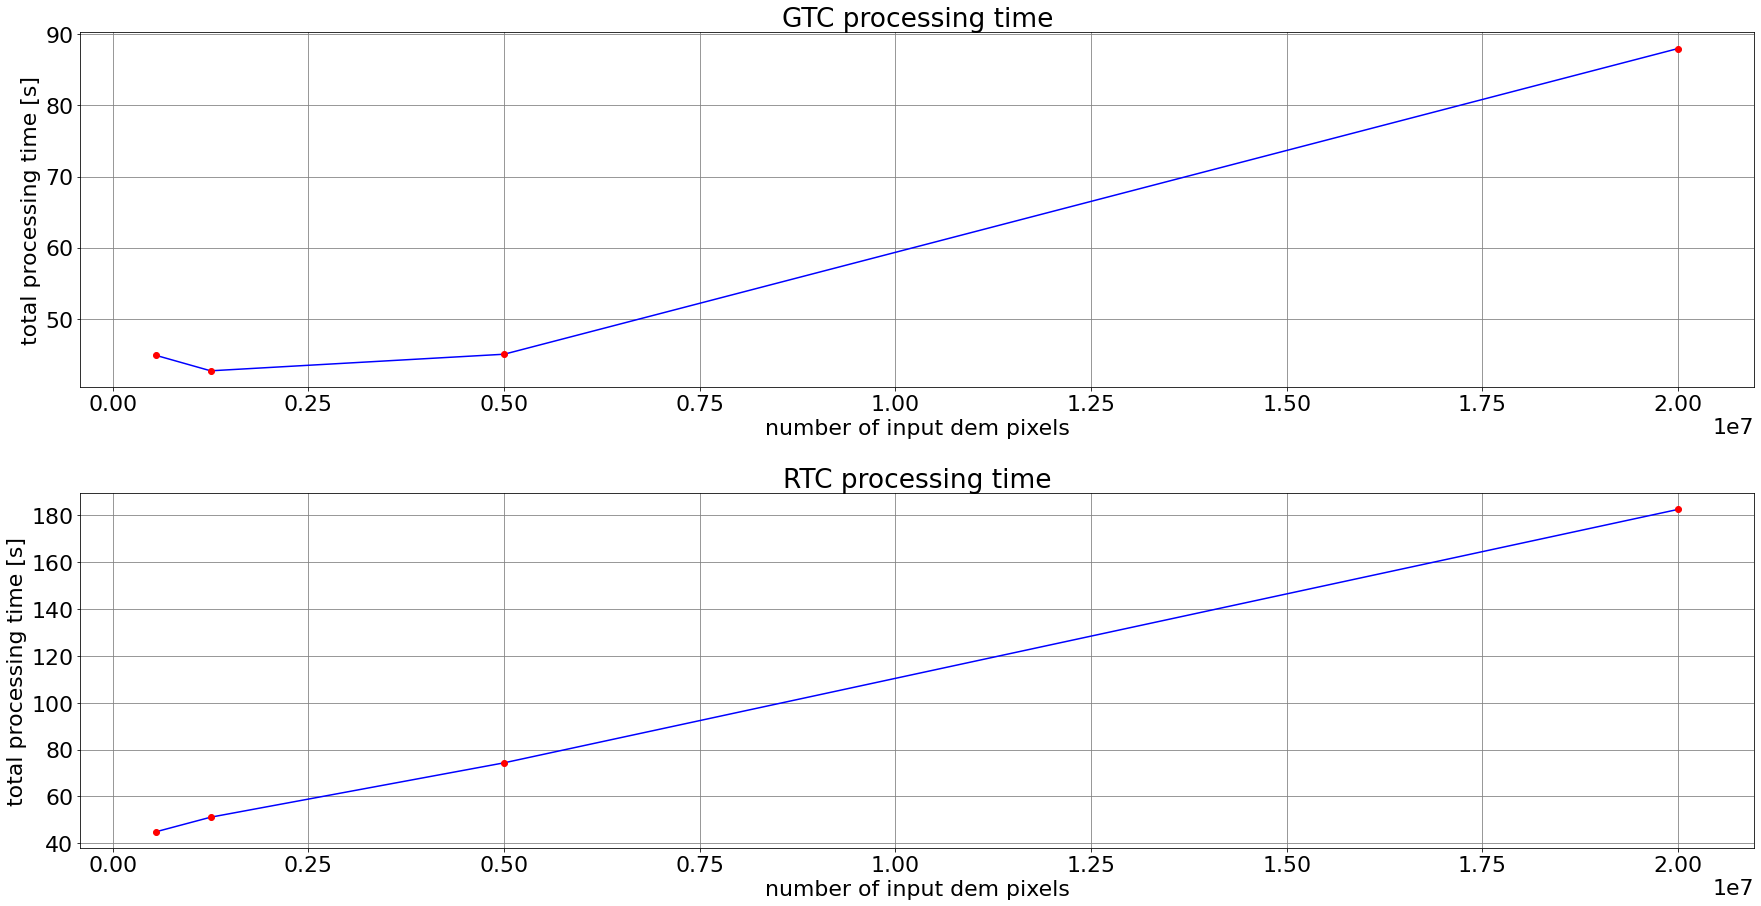

In [26]:
plt.figure(figsize=(20, 10))

f, axes = plt.subplots(nrows=2, figsize=(30, 15))
axes[0].plot(
    [rtc_05.size, rtc_10.size, rtc_20.size, rtc_30.size],
    [gtc_05_time, gtc_10_time, gtc_20_time, gtc_30_time],
    "b",
)
axes[0].plot(
    [rtc_05.size, rtc_10.size, rtc_20.size, rtc_30.size],
    [gtc_05_time, gtc_10_time, gtc_20_time, gtc_30_time],
    "ro",
)
axes[0].grid(c="gray")
axes[0].set_title("GTC processing time")
axes[0].set_xlabel("number of input dem pixels")
axes[0].set_ylabel("total processing time [s]")

axes[1].plot(
    [rtc_05.size, rtc_10.size, rtc_20.size, rtc_30.size],
    [rtc_05_time, rtc_10_time, rtc_20_time, rtc_30_time],
    "b",
)
axes[1].plot(
    [rtc_05.size, rtc_10.size, rtc_20.size, rtc_30.size],
    [rtc_05_time, rtc_10_time, rtc_20_time, rtc_30_time],
    "ro",
)
axes[1].grid(c="gray")
axes[1].set_title("RTC processing time")
axes[1].set_xlabel("number of input dem pixels")
axes[1].set_ylabel("total processing time [s]")


# set the spacing between subplots
plt.subplots_adjust(hspace=0.3)